In [1]:
import ipytest
import pytest
import random
import copy
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

ipytest.autoconfig()

In [6]:
def draw_maze(maze, filename, w=18, show_image=True):
    rows, cols = len(maze), len(maze[0])
    im = Image.new("RGB", (w*cols, w*rows))
    imd = ImageDraw.Draw(im)
    colors = ["white", "brown", "aqua"]
    for y, lines in enumerate(maze):
        for x, no in enumerate(lines):
            yy, xx = y*w, x*w
            imd.rectangle([(xx, yy), (xx+w, yy+w)], fill=colors[no])
    im.save(filename)

    if show_image:
        plt.imshow(im)
        plt.axis("off")
        plt.show()

def load_maze(filename):
    maze = json.load(open(filename, "r"))
    return maze

## 迷路の自動生成

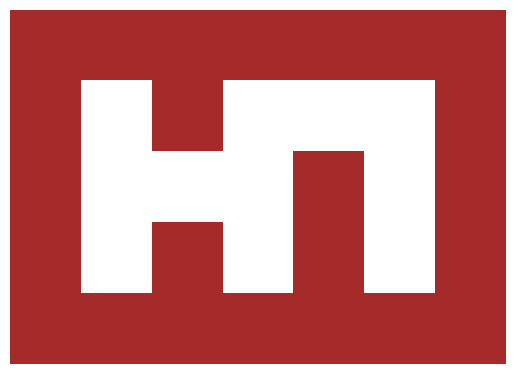

In [32]:
maze = [
    [1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1]
]

draw_maze(maze, "maze_test.png")

## 棒倒し法

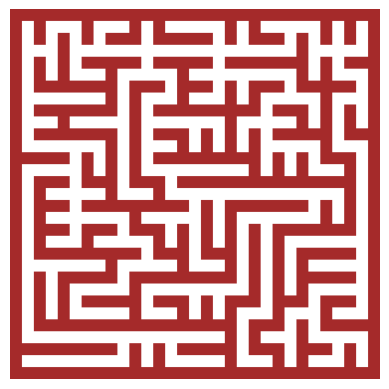

In [101]:
def make_maze_bar(columns, rows):
    directions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
    maze = [[1]*columns if i==0 or i==rows-1 else [1]+[0]*(columns-2)+[1] for i in range(rows)]

    for y in range(2, rows-2, 2):
        if y > 2 and len(directions)==4: directions.remove([0, -1])
        for x in range(2, columns-2, 2):
            maze[y][x] = 1

            random.shuffle(directions)
            for dx, dy in directions:
                if maze[y+dy][x+dx] == 0:
                    maze[y+dy][x+dx] = 1
                    break
    
    return maze

maze = make_maze_bar(31, 31)
draw_maze(maze, "Bar_maze.png")

## 穴掘り法

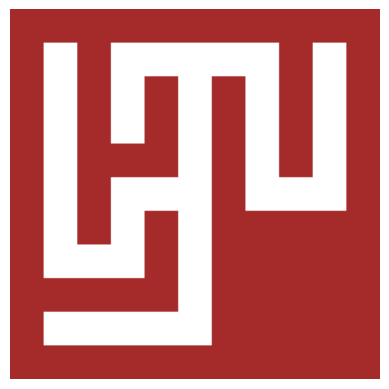

In [314]:
def make_maze_dig(columns, rows):
    directions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
    maze = [[1]*columns for _ in range(rows)]
    maze[1][1] = 0

    def _dig(x, y):
        random.shuffle(directions)
        for dx, dy in directions:
            x1, y1 = x+dx, y+dy
            x2, y2 = x+dx*2, y+dy*2

            if (x2 < 0 or x2 >= columns-1) or (y2 < 0 or y2 >= rows-1) or (maze[y2][x2] == 0): continue

            maze[y1][x1], maze[y2][x2] = 0, 0
            _dig(x2, y2)

    _dig(1, 1)
    return maze

maze = make_maze_dig(11, 11)
draw_maze(maze, "Dig_maze.png")

## クラスタリング法

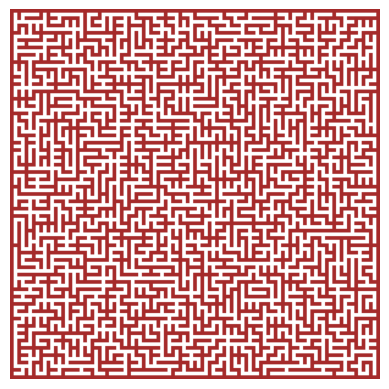

In [25]:
# クラスタリング法

def make_maze_cluster(columns, rows):
    maze = [[1]*columns for _ in range(rows)]
    # maze = [["W"]*columns for _ in range(rows)]
    room_y, room_x = rows//2, columns//2
    walls = []

    for y in range(room_y):
        for x in range(room_x):
            maze[y*2+1][x*2+1] = 0
            
            if y != room_y-1: walls.append([(x, y), (x, y+1)])
            if x != room_x-1: walls.append([(x, y), (x+1, y)])

    rooms = [no for no in range(room_x*room_y)]

    random.shuffle(walls)

    # 迷路に部屋番号を振る
    # for wall in walls:
    #     (x1, y1), (x2, y2) = wall
    #     room1, room2 = rooms[y1*room_x+x1], rooms[y2*room_x+x2]

    #     maze[y1*2+1][x1*2+1] = room1
    #     maze[y2*2+1][x2*2+1] = room2

    # for m in maze:
    #     print(*m)

    # return

    for wall in walls:
        (x1, y1), (x2, y2) = wall
        room1, room2 = rooms[y1*room_x+x1], rooms[y2*room_x+x2]

        if room1 == room2: continue

        if x1 == x2:
            maze[y1*2+2][x1*2+1] = 0
        else:
            maze[y1*2+1][x1*2+2] = 0

        if room1 > room2:
            room1, room2 = room2, room1

        for i in range(len(rooms)):
            if rooms[i] == room1:
                rooms[i] = room2

    return maze

maze = make_maze_cluster(101, 101)
draw_maze(maze, "Cluster_maze.png")

## 迷路の深さ優先探索

Goal 126 Steps


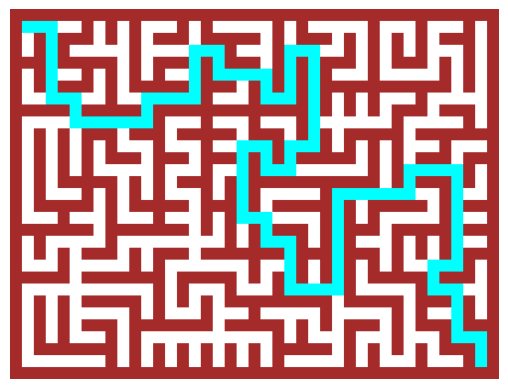

CPU times: total: 78.1 ms
Wall time: 112 ms


In [34]:
%%time

ROAD, WALL, CHECKED = 0, 1, 2

def maze_search_dfs(maze, curr_pos, goal_pos, level=0, route=[]):
    x, y = curr_pos
    maze[y][x] = CHECKED
    route.append(curr_pos)

    if curr_pos == goal_pos:
        print(f"Goal {level} Steps")
        return route
    
    for dx, dy in [[0, -1], [0, 1], [-1, 0], [1, 0]]:
        # [上, 下, 左, 右]
        x1, y1 = x+dx, y+dy

        if maze[y1][x1] == ROAD:
            result = maze_search_dfs(maze, [x1, y1], goal_pos, level+1, route)
            if result: return result

    route.pop()

    return None

maze = load_maze("maze_test.json")
route = maze_search_dfs(copy.deepcopy(maze), [1, 1], [39, 29])
for x, y in route:
    maze[y][x] = 2
draw_maze(maze, "maze_dfs.png")
    

## 幅優先探索

Goal: 126 Steps


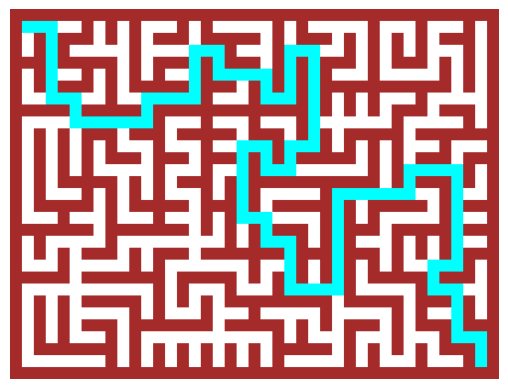

CPU times: total: 109 ms
Wall time: 214 ms


In [32]:
%%time

def maze_search_bfs(maze, start_pos, goal_pos, level=0, route=[]):
    directions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
    rows, cols = len(maze), len(maze[0])
    queue = [[start_pos, level, route]]

    while queue:
        pos, level, route = queue.pop(0)
        x, y = pos
        route.append(pos)

        if pos == goal_pos:
            print(f"Goal: {level} Steps")
            return route

        for dx, dy in directions:
            x1, y1 = x+dx, y+dy

            if x1 < 0 or x1 >= cols or y1 < 0 or y1 >= rows or maze[y1][x1] == 1 or [x1, y1] in route:
                continue

            queue.append([[x1, y1], level+1, copy.deepcopy(route)])

    return [], -1

maze = load_maze("maze_test.json")
route = maze_search_bfs(maze, [1, 1], [39, 29])
for x, y in route:
    maze[y][x] = 2
draw_maze(maze, "maze_bfs.png")

## 電車の乗り換え問題

### 問題
都市Aから都市Fへ電車を利用して移動する．このとき，次のように路線を乗り継ぐ方法がある．都市Aから都市Fへ最も安く移動するための経路を求めよ．

路線１：A-B（運賃：200円）  
路線２：A-C（運賃：170円）  
路線３：A-D（運賃：170円）  
路線４：B-F（運賃：300円）  
路線５：C-E（運賃：120円）  
路線６：D-E（運賃：150円）  
路線７：E-F（運賃：150円）  

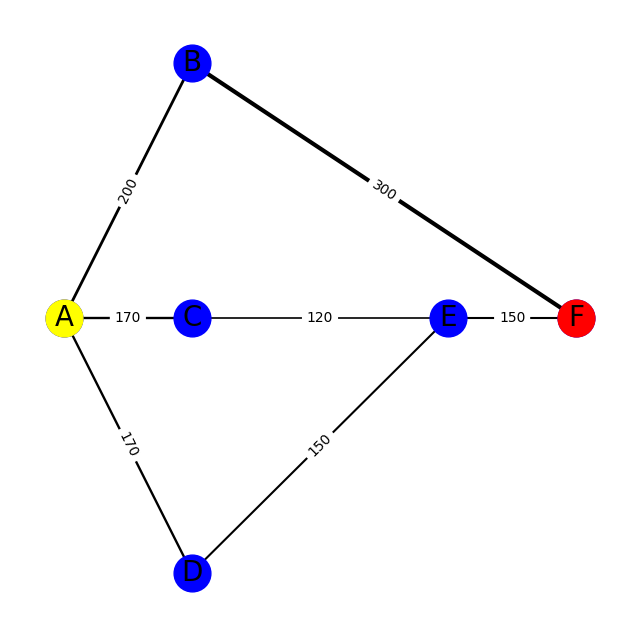

In [2]:
fare_graph = {
    "A": {"B": 200, "C": 170, "D": 170},
    "B": {"F": 300},
    "C": {"E": 120},
    "D": {"E": 150},
    "E": {"F": 150},
}

pos = {"A": (0, 0), "B": (1, 1), "C": (1, 0), "D": (1, -1), "E": (3, 0), "F": (4, 0)}

def draw_graph(graph: dict, filename: str, pos: dict=None, root:list=None, show_image: bool=True, start_node: str="A", goal_node: str="F"):
    """グラフを描画する
    Args:
        graph (dict): グラフ
        filename (str): 画像ファイル名
        pos (dict, optional): ノードの位置. Defaults to None.
        root (list, optional): ルート. Defaults to None.
        show_image (bool, optional): 画像を表示するかどうか. Defaults to True.
        start_node (str, optional): 開始ノード. Defaults to "A".
        goal_node (str, optional): 終了ノード. Defaults to "F".

    Returns:
        None

    Notes:
        - グラフは辞書型で、キーが始点、値が終点と運賃の辞書である
        - ノードの色は青，エッジの色は黒
        - エッジの重み（太さ）は運賃に比例
    """
    plt.figure(figsize=(8, 8))
    np.random.seed(123)
    
    G = nx.Graph()
    for start, edges in graph.items():
        for goal, fare in edges.items():
            G.add_edge(start, goal, weight=fare)

    if pos is None:
        pos = nx.spring_layout(G)
    else:
        pos = {node: (pos[node][0], pos[node][1]) for node in G.nodes}


    edge_labels = {(start, goal): fare for start, goal, fare in G.edges.data("weight")}
    nx.draw_networkx_labels(G, pos, font_size=20, font_color="black", font_family="sans-serif")
    nx.draw_networkx_nodes(G, pos, node_color="blue", node_size=700)
    nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color="yellow", node_size=700)
    nx.draw_networkx_nodes(G, pos, nodelist=[goal_node], node_color="red", node_size=700)
    nx.draw_networkx_edges(G, pos, width=[G.edges[start, goal]["weight"]/100 for start, goal in G.edges])
    if root is not None:
        nx.draw_networkx_edges(G, pos, edgelist=[(root[i], root[i+1]) for i in range(len(root)-1)], edge_color="yellow", width=3)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="black")
    plt.axis("off")
    plt.savefig(filename)
    if show_image: plt.show()

draw_graph(fare_graph, "fare_graph.png", pos)

440円: ['A', 'C', 'E', 'F']


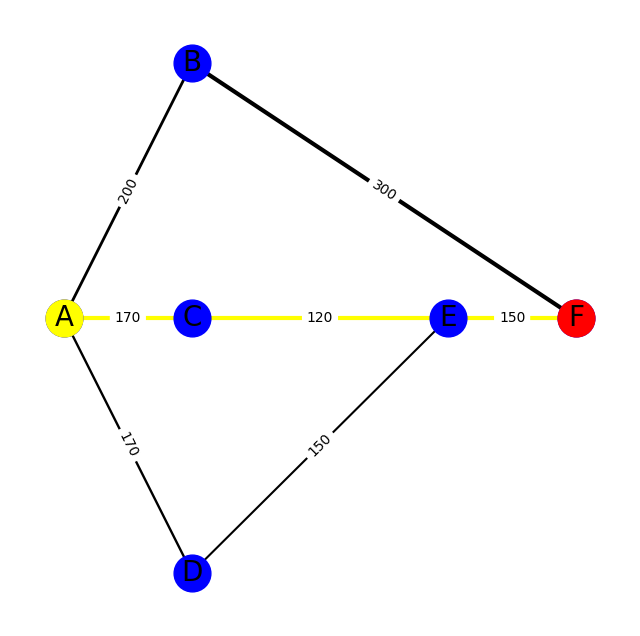

In [3]:
def dfs(graph, goal_node, start_node):
    min_fare = float("inf")
    min_route = []

    def _dfs(node, route, fare):
        nonlocal min_fare, min_route

        if node == goal_node:
            if fare < min_fare:
                min_fare = fare
                min_route = route
            return

        for next_node, next_fare in graph[node].items():
            if next_node in route: continue
            _dfs(next_node, route+[next_node], fare+next_fare)

    _dfs(start_node, [start_node], 0)
    return min_route, min_fare

    

route, fare = dfs(fare_graph, "F", "A")
print(f"{fare}円: {route}")
draw_graph(fare_graph, "fare_graph_dfs.png", pos, route)

440円: ['A', 'C', 'E', 'F']


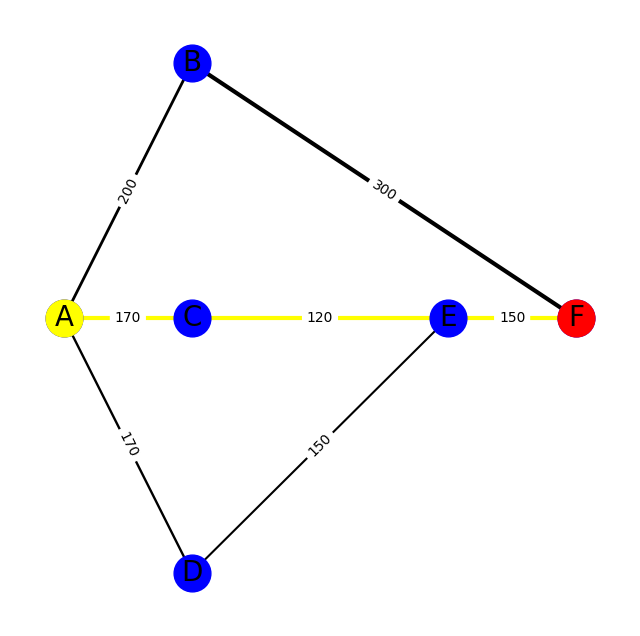

In [4]:
def bfs(graph, goal_node, start_node):
    queue = [[start_node, [start_node], 0]]
    min_fare = float("inf")
    min_route = []

    while queue:
        node, route, fare = queue.pop(0)

        if node == goal_node:
            if fare < min_fare:
                min_fare = fare
                min_route = route
            continue

        for next_node, next_fare in graph[node].items():
            if next_node in route: continue
            queue.append([next_node, route+[next_node], fare+next_fare])

    return min_route, min_fare

route, fare = bfs(fare_graph, "F", "A")
print(f"{fare}円: {route}")
draw_graph(fare_graph, "fare_graph_bfs.png", pos, route)



## ナンプレ

In [11]:
data = [
    [0, 0, 4, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 7, 0, 6, 0, 0],
    [0, 0, 6, 0, 8, 0, 0, 0, 0],
    [2, 0, 0, 4, 5, 0, 3, 9, 0],
    [6, 9, 0, 2, 3, 8, 1, 7, 0],
    [4, 0, 0, 1, 6, 9, 2, 0, 0],
    [0, 0, 8, 0, 0, 5, 0, 6, 0],
    [0, 0, 0, 0, 0, 0, 8, 0, 2],
    [0, 6, 0, 0, 2, 3, 0, 4, 0]
]

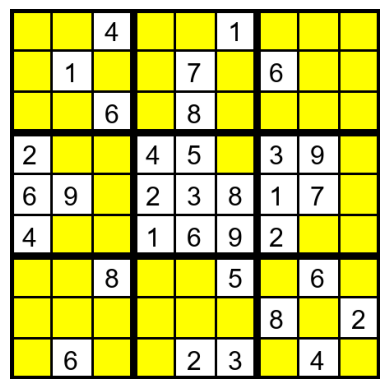

In [12]:
def draw_numplace(data: list, filename: str, show_image: bool=True):
    """ナンプレを描画する

    Args:
        data (list): ナンプレのデータ
        filename (str): 画像ファイル名
        show_image (bool, optional): 画像を表示するかどうか. Defaults to True.

    Returns:
        None
    """

    w = 50
    font = ImageFont.truetype("arial.ttf", 32)
    im = Image.new("RGB", (w*9, w*9), "white")
    imd = ImageDraw.Draw(im)

    for y in range(9):
        for x in range(9):
            if data[y][x] == 0:
                imd.rectangle([(x*w, y*w), (x*w+w, y*w+w)], fill="yellow")
                continue
            imd.text((x*w+15, y*w+10), str(data[y][x]), font=font, fill="black")

    for y in range(10):
        imd.line([(0, y*w), (w*9, y*w)], fill="black", width=3)
        imd.line([(y*w, 0), (y*w, w*9)], fill="black", width=3)

    for y in range(0, 10, 3):
        imd.line([(0, y*w), (w*9, y*w)], fill="black", width=9)
        imd.line([(y*w, 0), (y*w, w*9)], fill="black", width=9)

    im.save(filename)

    if show_image:
        plt.imshow(im)
        plt.axis("off")
        plt.show()

draw_numplace(data, "numplace.png")

In [7]:
def validate_condition(ans: list) -> bool:
    """ナンプレの制約を満たしているかどうかを検証する

    Args:
        ans (list): ナンプレの解答

    Returns:
        bool: 制約を満たしているかどうか

    Notes:
        - 各行、各列、各3x3ブロックには1から9までの数字が1つずつ含まれる
    """

    for i in range(9):
        if len(set(ans[i])) != 9: return False
        if len(set([ans[j][i] for j in range(9)])) != 9: return False

    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            if len(set([ans[i+k][j+l] for k in range(3) for l in range(3)])) != 9: return False

    return True

## ナンプレを解く

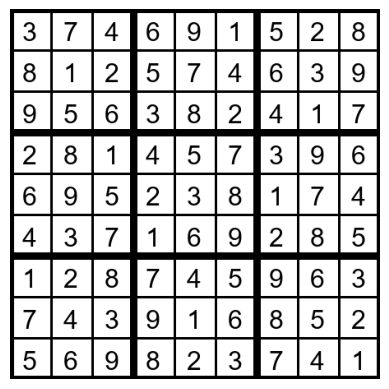

Validation: True


In [8]:
def solve_numplace(data: list) -> list:
    """ナンプレを解く

    Args:
        data (list): ナンプレのデータ

    Returns:
        list: 解答

    Notes:
        - 空欄は0で表される
    """

    def is_valid(data, x, y, num):
        # 同じ行、同じ列、同じ3x3ブロックに同じ数字がないかどうかを確認
        for i in range(9):
            if data[y][i] == num or data[i][x] == num:
                return False

        for i in range(3):
            for j in range(3):
                if data[(y//3)*3+i][(x//3)*3+j] == num:
                    return False

        return True

    def _solve(data):
        # 空欄を埋める
        for y in range(len(data)):
            for x in range(len(data[0])):
                if data[y][x] == 0:
                    for num in range(1, 10):
                        if is_valid(data, x, y, num):
                            data[y][x] = num
                            if _solve(data):
                                return True
                            data[y][x] = 0
                    return False
        return True

    _solve(data)
    return data

data = solve_numplace(data)
draw_numplace(data, "numplace_solve.png")
print(f"Validation: {validate_condition(data)}")

## ナンプレを生成する

========== Answer ==========


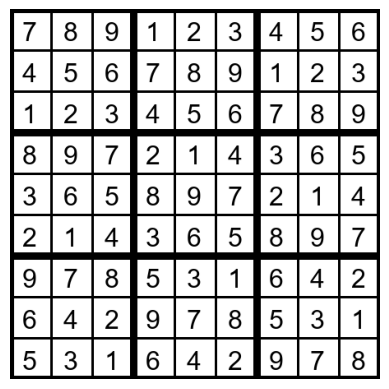

Validation: True

========== Problem ==========


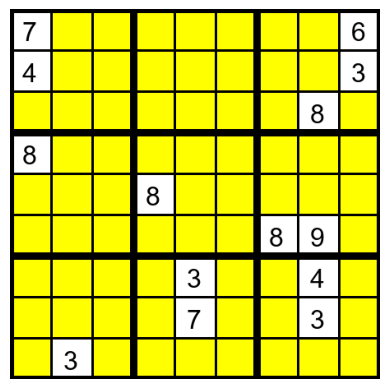

========== Solve ==========


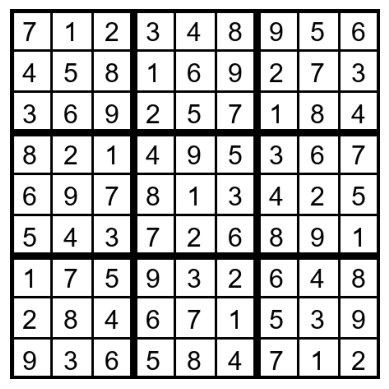

Validation: True


In [37]:
def gen_numplace(ans=None, num_operation=300, mutation_rate=0.7,blank_rate=0.3) -> tuple:
    """ナンプレを生成する

    Args:
        num_operation (int, optional): 操作回数. Defaults to 300.
        mutation_rate (float, optional): 変異率. Defaults to 0.7.
        blank_rate (float, optional): 空欄率. Defaults to 0.3.

    Returns:
        tuple: ナンプレの解答と問題

    Notes:
        - 空欄は0で表される
        - 手順
            - 適当な完成されたナンプレを生成
            - 以下を適当な回数繰り返す
                - ランダムに上3行と下3行を入れ替える
                - ランダムに3x3の枠内の行を入れ替える
                - ランダムにナンプレを転置
            - ランダムに数字を0に変更
    """

    if ans is None:
        ans = [[0]*9 for _ in range(9)]
        ans = solve_numplace(ans)

    for _ in range(num_operation):
        if random.random() < mutation_rate:
            ans[0:3], ans[6:9] = ans[6:9], ans[0:3]
        if random.random() < mutation_rate:
            ans = [[ans[i][j] for j in range(9)] for i in range(9)]
        if random.random() < mutation_rate:
            for i in range(0, 9, 3):
                if random.random() < mutation_rate:
                    ans[i:i+3] = ans[i:i+3][::-1]

    # if validate_condition(ans):
    #     problem = copy.deepcopy(ans)
    #     for y in range(9):
    #         for x in range(9):
    #             if random.random() < blank_rate:
    #                 problem[y][x] = 0
    # else:
    #     raise ValueError("Invalid Numplace")
    problem = copy.deepcopy(ans)
    for y in range(9):
        for x in range(9):
            if random.random() < blank_rate:
                problem[y][x] = 0

    return (ans, problem)

ans = None

ans, problem = gen_numplace(ans, blank_rate=0.8)
print("="*10, "Answer", "="*10)
draw_numplace(ans, "numplace_ans.png")
print(f"Validation: {validate_condition(ans)}\n")

print("="*10, "Problem", "="*10)
draw_numplace(problem, "numplace_problem.png")

print("="*10, "Solve", "="*10)
data = solve_numplace(problem)
draw_numplace(data, "numplace_solve.png")
print(f"Validation: {validate_condition(data)}")
